In [23]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

from xgboost import XGBClassifier

In [2]:
df = pd.read_excel("Telco_customer_churn_adapted_v2.xlsx")
df.head()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0


In [4]:
df.drop(["Customer ID", "Latitude", "Longitude"], axis=1, inplace=True)
df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,CLTV (Predicted Thou. IDR)
0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,4210.7
1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,3511.3
2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,6983.6
3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,6503.9
4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,6942.0


In [6]:
def encode_data(df):
    if df.dtype == "object":
        le = LabelEncoder()
        df = le.fit_transform(df)
    return df

In [8]:
df = df.apply(lambda x: encode_data(x))
df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,CLTV (Predicted Thou. IDR)
0,2,1,2,2,2,0,0,0,0,2,70.005,1,4210.7
1,2,1,0,0,0,0,0,0,0,3,91.910,1,3511.3
2,8,1,0,0,0,2,0,2,2,3,129.545,1,6983.6
3,28,1,0,0,0,2,1,2,2,3,136.240,1,6503.9
4,49,1,0,0,2,2,0,2,2,1,134.810,1,6942.0


In [11]:
fig = px.bar(df.corr()['Churn Label'].sort_values(ascending = False),
             color = 'value')
fig.show()

In [13]:
over = SMOTE(sampling_strategy=1)

X = df.drop(["Churn Label"], axis=1)
y = df["Churn Label"]

In [14]:
X, y = over.fit_resample(X, y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8278, 12), (2070, 12), (8278,), (2070,))

In [19]:
def model(method, x_train, y_train, x_test, y_test):
    # Train the model
    method.fit(x_train, y_train)
    
    # Make predictions on test data and calculate confusion matrix
    predictions = method.predict(x_test)
    c_matrix = confusion_matrix(y_test, predictions)
    
    # Calculate label percentages and create label strings with counts and percentages
    percentages = (c_matrix / np.sum(c_matrix, axis=1)[:, np.newaxis]).round(2) * 100
    labels = [[f"{c_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
    labels = np.asarray(labels)
    
    # Plot confusion matrix with labeled counts and percentages
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    
    # Evaluate model performance and print results
    print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
    print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))

In [24]:
xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

ROC AUC:  80.90%
Model accuracy:  80.97%
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1011
           1       0.80      0.84      0.82      1059

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070



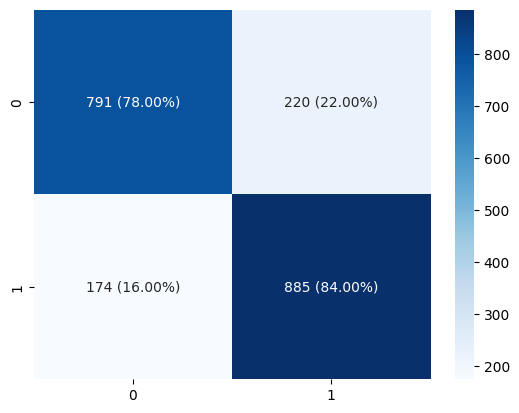

In [25]:
model(xgb, X_train, y_train, X_test, y_test)